# Assignment 4
## Due May 16th at 12:00

Please do not chance any provided variable name. Read carefully the instructions in the exercise PDF and in this notebook. Add your solutions at `YOUR CODE HERE` and remove the corresponding `raise NotImplementedError()`.
Before submitting: Please make sure, that your notebook can be executed from top to bottom without an error (Menu -> Kernel -> Restart & Run all). 

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

np.random.seed(42)

## Exercise 1

### a)

In [10]:
candies = pd.read_csv("candy-data.csv")

names = candies['competitorname']
ys = candies['chocolate']
xs = candies.drop(['competitorname', 'chocolate'], axis=1)

In [32]:
# split (xs, ys) into (xs_train, ys_train) and (xs_test, ys_test)

# xs_train, xs_test = sklearn.model_selection.train_test_split(xs, test_size=1/3)
# ys_train, ys_test = sklearn.model_selection.train_test_split(ys, test_size=1/3)

xs_train = xs[:int(len(xs)*2/3)]
xs_test = xs[int(len(xs)*2/3):]
ys_train = ys[:int(len(xs)*2/3)]
ys_test = ys[int(len(xs)*2/3):]

print(xs_train.shape, xs_test.shape)
print(ys_train.shape, ys_test.shape)

(56, 11) (29, 11)
(56,) (29,)


### b)

In [37]:
reg = LogisticRegression(solver='liblinear').fit(xs_train, ys_train)

pred = reg.predict(xs_test)

# acc = reg.score(xs_test, ys_test)

acc = (pred == ys_test).mean()

assert acc == reg.score(xs_test, ys_test), "Probably a rounding error"

print(acc)

0.8275862068965517


### c)

In [49]:
Cs =  [0.001, 0.01, 0.1, 1, 10, 100, 1000]

array([0.46      , 0.51333333, 0.94666667, 0.94666667, 0.93      ,
       0.94666667, 0.94666667])

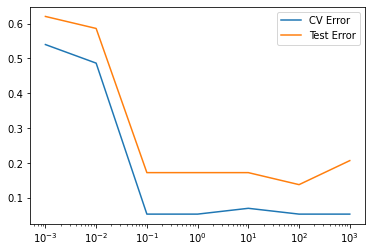

 Lowest CV_Error: 0.053333333333333344 on param C=0.1
 Lowest CV_Error: 0.13793103448275867 on param C=100


In [78]:
# Run cross validation using GridSearchCV
CV = GridSearchCV(reg, {'C':Cs}, cv=10).fit(xs_train, ys_train)
    
# Compute cross validation error
cv_scores = CV.cv_results_['mean_test_score']

# Compute test error
test_errors = []
for C in Cs:
    reg = LogisticRegression(solver='liblinear', C=C).fit(xs_train, ys_train)
    test_errors.append(1-reg.score(xs_test, ys_test))

# Plot results in new figure
fig, axis = plt.subplots(1)
axis.set_xscale('log')
axis.plot(Cs, (1-cv_scores))
axis.plot(Cs, test_errors)
axis.legend(['CV Error', 'Test Error'])
plt.show()


print(f' Lowest CV_Error: {(1-cv_scores).min()} on param C={Cs[(1-cv_errors).argmin()]}')
print(f' Lowest CV_Error: {np.min(test_errors)} on param C={Cs[np.argmin(test_errors)]}')



### Comment. Does CV choose the best C? How do different values of C compare with respect to over/underfitting?

Answer: 
The best CV error is achieved on C=0.1  
The best Test error is achieved on C=100  
So the CV does not choost the best C.

We can clearly soo some underfitting for C=0.001, C=0.01  
And some overfitting for C=1000

### d) 

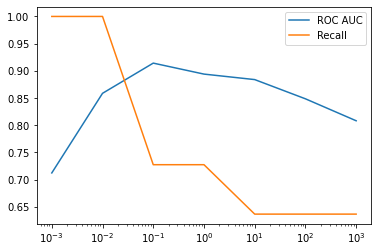

Wrt. ROC AUC, param C=0.1 performs best with a AUC of 0.9141414141414141
Wrt. Recall, param C=0.001 (and C=0.01) performs best with a recall of 1.0


In [128]:
from sklearn.metrics import roc_curve, roc_auc_score

# For each C compute the recall, auc and roc_curver
rocs = []
roc_aucs = []
recalls = []
fp_rates =[]
for C in Cs:
    reg = LogisticRegression(solver='liblinear', C=C).fit(xs_train, ys_train)
    pred_prob = reg.predict_proba(xs_test)[:, 1]
    pred = reg.predict(xs_test)
    #rocs.append(roc_curve(ys_test, pred))
    #roc_aucs.append(roc_auc_score(ys_test, pred))
    
    rocs.append(roc_curve(ys_test, pred_prob))
    roc_aucs.append(roc_auc_score(ys_test, pred_prob))
    
    
    tp = pred[pred == ys_test].sum()
    fn = ys_test[pred != ys_test].sum()
    recalls.append(tp / (tp + fn))
    
    fp = pred[pred != ys_test].sum()
    negs = ys_test.size - np.count_nonzero(ys_test)
    fp_rates.append(fp / negs)

# Plot recall and AUC
fig, axis = plt.subplots(1)
axis.plot(Cs, roc_aucs)
axis.plot(Cs, recalls)
axis.legend(['ROC AUC', 'Recall'])
axis.set_xscale('log')
plt.show()

print(f'Wrt. ROC AUC, param C={Cs[np.argmax(roc_aucs)]} performs best with a AUC of {np.max(roc_aucs)}')
print(f'Wrt. Recall, param C={Cs[np.argmax(recalls)]} (and C=0.01) performs best with a recall of {np.max(recalls)}')

### e)

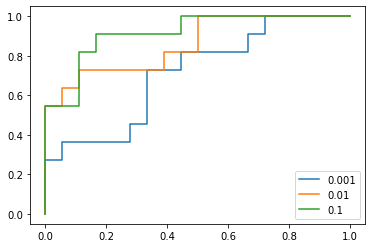

In [119]:
# Plot the roc_curve of the solutions that perform best in some criterion
fig, ax = plt.subplots()
for C in [0.001, 0.01, 0.1]:
    i = Cs.index(C)
    ax.plot(rocs[i][0], rocs[i][1])
ax.legend(Cs)
plt.show()

### Name 3 desired properties of a classifier; for each of these decide which value of $C$ you would choose.

Answer: High Recall, High ROC AUC, Low False Positive Rate


In [130]:

print(f'Wrt. ROC AUC, param C={Cs[np.argmax(roc_aucs)]} performs best with a AUC of {np.max(roc_aucs)}')
print(f'Wrt. Recall, param C={Cs[np.argmax(recalls)]} (and C=0.01) performs best with a recall of {np.max(recalls)}')
print(f'Wrt. False Positive Rate, param C={Cs[np.argmin(fp_rates)]} performs best with a fp_rate of {np.min(fp_rates)}')


Wrt. ROC AUC, param C=0.1 performs best with a AUC of 0.9141414141414141
Wrt. Recall, param C=0.001 (and C=0.01) performs best with a recall of 1.0
Wrt. False Positive Rate, param C=100 performs best with a fp_rate of 0.0


### (f) Which cardinal crime have we just committed in (e)?

We chose hyperparameters looking at the test set

The test set is now part of our training process and not an actual test set anymore.

## Exercise 2

### a)
\begin{align*}
    P(Y \mid X,w) &= \mathcal{N}(0, \sigma^2 I) + Xw \\
    &= \mathcal{N}(Xw, \sigma^2 I)
\end{align*}

### b)

\begin{align*}
    \int P(Y\mid X,w)P(w) dw
    &= \int \frac{P(Y,X,w)}{P(X,w)} P(w) dw \\
    \text{as } X\perp\!\!\!\perp w:\\
    &= \int \frac{P(Y,X,w)}{P(X)P(w)} P(w) dw \\
    &= \int \frac{P(Y,X,w)}{P(X)} dw \\
    &= \int P(Y, w \mid X) dw \\
    &= P(Y\mid X) \\
    P(w \mid X,Y) &= \frac{P(Y\mid X,w)P(w)}{\int P(Y\mid X,w)P(w) dw} \\
    &= \frac{P(Y\mid X,w)P(w)}{P(Y\mid X)} \\
\end{align*}

### c) 

\begin{align*}
    w^* &= \arg\max_w P(w\mid X, Y) \\
    &= \arg\max_w \frac{P(Y\mid X,w)P(w)}{P(Y\mid X)} \\
    &= \arg\max_w \log \frac{P(Y\mid X,w)P(w)}{P(Y\mid X)} \\
    &= \arg\max_w \log P(Y\mid X,w) + \log P(w) - \underbrace{\log P(Y\mid X)}_{\text{indep. of } w} \\
    &= \arg\max_w \log \mathcal{N}(Xw, \sigma^2 I) + \log\mathcal{N}(0, \tau^2 I)\\
    &= \arg\max_w \log \exp\left(-\frac{1}{2} (Y-Xw)^T (\sigma^2I)^{-1} (Y-Xw)\right) + \log\exp\left(-\frac{1}{2} (w-0)^T (\tau^2I)^{-1} (w-0)\right)\\
    &= \arg\max_w -\frac{1}{2\sigma^2} (Y-Xw)^T I(Y-Xw)  -\frac{1}{2\tau^2} w^T I w\\
    &= \arg\max_w -\frac{1}{2\sigma^2} \|Y-Xw\|^2  -\frac{1}{2\tau^2} \|w\|^2 \\
    &= \arg\min_w \|Y-Xw\|^2 +\frac{\sigma^2}{\tau^2} \|w\|^2 \\
\end{align*}
This is equivalent to Ridge regression with $\lambda = \frac{\sigma^2}{\tau^2}$